In [78]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFilter
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, classification_report

In [115]:
# Data Extraction & Data Augmentation (Data Preprocessing)
import cv2
import os
import pandas as pd
from datetime import datetime

def normalize_frame(frame):
    # Normalize pixel values to the range [0, 1]
    normalized_frame = frame.astype('float32') / 255.0
    return normalized_frame

def extract_and_label_videos(video_data, output_folder, target_size=(255, 255)):
    for entry in video_data.itertuples(index=False):
        video_name = entry[0]
        start_time = entry[1]
        end_time = entry[2]
        feature = entry[3]

        # Create a folder for each feature if it doesn't exist
        feature_folder = os.path.join(output_folder, f"feature_{feature}")
        os.makedirs(feature_folder, exist_ok=True)

        # Read the video file
        video_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/AML Final Project (Yap)/AML_Group_Assignment", video_name)
        cap = cv2.VideoCapture(video_path)

        # Convert timestamp strings to seconds
        start_time_seconds = datetime.strptime(start_time.strip(), "%M:%S").minute * 60 + datetime.strptime(start_time.strip(), "%M:%S").second
        end_time_seconds = datetime.strptime(end_time.strip(), "%M:%S").minute * 60 + datetime.strptime(end_time.strip(), "%M:%S").second

        # Set the start and end frames based on timestamps
        start_frame = int(start_time_seconds * cap.get(cv2.CAP_PROP_FPS))
        end_frame = int(end_time_seconds * cap.get(cv2.CAP_PROP_FPS))

        # Set the video capture to the start frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

        # Read, normalize, and write frames to a new video file
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
                break

            # Resize the frame to the target size
            resized_frame = cv2.resize(frame, target_size)

            # Normalize the frame
            normalized_frame = normalize_frame(resized_frame)

            frames.append(normalized_frame)

        # Save normalized frames to a new video file
        output_video_name = f"{video_name}_{start_time}_{end_time}_normalized.mp4"
        output_video_path = os.path.join(feature_folder, output_video_name)
        out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), cap.get(cv2.CAP_PROP_FPS), target_size)
        for normalized_frame in frames:
            out.write((normalized_frame * 255).astype('uint8'))  # Convert back to uint8 before writing

        # Release the video capture and writer
        cap.release()
        out.release()

if __name__ == "__main__":
    # Read data from the Excel file
    excel_path = "/content/drive/MyDrive/Colab Notebooks/AML Final Project (Yap)/metadata.xlsx"
    video_data = pd.read_excel(excel_path)

    # Specify the output folder
    output_folder = "/content/drive/MyDrive/Colab Notebooks/AML Final Project (Yap)/Processed Video"

    # Set the target size for resizing
    target_size = (64, 64)

    extract_and_label_videos(video_data, output_folder, target_size)


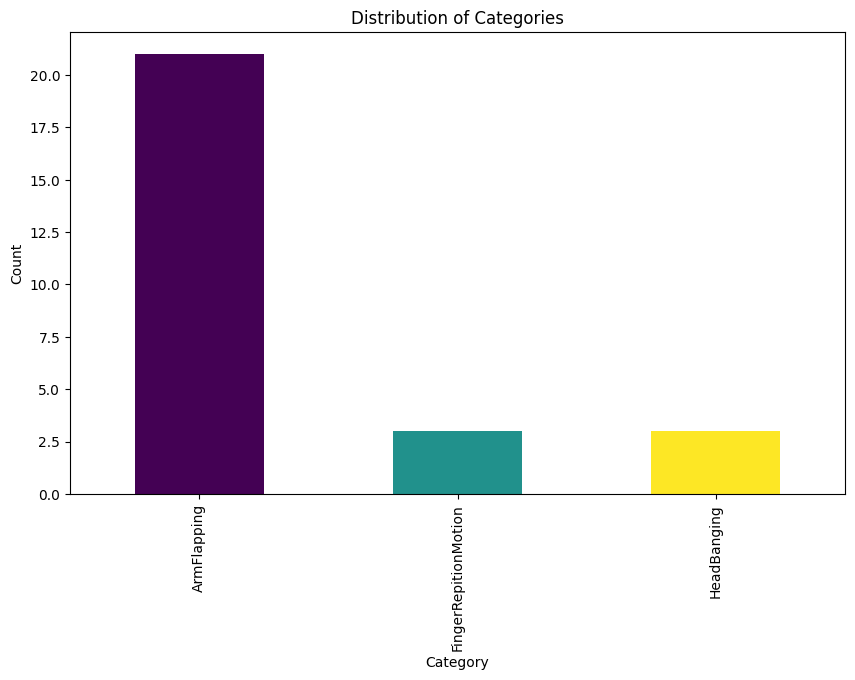

In [127]:
total_features = video_data['Features']

# Get the unique categories and their counts
category_counts = total_features.value_counts()

# Get distinct colors for each category
colors = plt.cm.viridis(np.linspace(0, 1, len(category_counts)))

# Plot the bar graph with different colors for each category
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [116]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30

# Specify the directory containing the processed videos.
DATASET_DIR = "/content/drive/MyDrive/Colab Notebooks/AML Final Project (Yap)/Processed Video"

# Specify the list containing the names of the features used for training.
# Feel free to choose any set of features.
CLASSES_LIST = ["feature_ArmFlapping", "feature_FingerRepitionMotion", "feature_HeadBanging"]

In [117]:
# Define a function to add noise to an image
augment=True  #set to do the data augmentation
def add_noise_and_blur(image):
    # Add noise
    noise = np.random.normal(loc=0, scale=0.05, size=image.shape)
    noisy_image = np.clip(image + noise, 0.0, 1.0)

    # Apply Gaussian blur
    pil_image = Image.fromarray((noisy_image * 255).astype(np.uint8))
    blurred_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))

    # Convert back to numpy array and normalize
    blurred_image = np.array(blurred_image) / 255.0

    return blurred_image

# Create an instance of the ImageDataGenerator with the custom preprocessing function
data_generator = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=add_noise_and_blur,
    rotation_range=20,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.2,
    zoom_range=0.0,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [118]:
def frames_extraction(video_path, augment=augment):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()

        if not success:
            break

        if augment:
            frame = frame.reshape((1,) + frame.shape)
            augmented_frame = next(data_generator.flow(frame))[0]
            frames_list.append(normalize_frame(augmented_frame))
        else:
            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
            normalized_frame = normalize_frame(resized_frame)
            frames_list.append(normalized_frame)

    video_reader.release()
    return frames_list

In [119]:
def create_dataset(augment = augment):

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [120]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

Extracting Data of Class: feature_ArmFlapping
Extracting Data of Class: feature_FingerRepitionMotion
Extracting Data of Class: feature_HeadBanging


In [121]:
def create_convlstm_model():


    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.3)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.7, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.7, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.7)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))



    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [122]:
# Split the Data into Train and Test Set based on Folds
K_FOLDS = 5
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
for train_index, test_index in skf.split(features, labels.reshape(-1, 1)):
    features_train, features_test = features[train_index], features[test_index]
    labels_train, labels_test = one_hot_encoded_labels[train_index], one_hot_encoded_labels[test_index]

# Create an empty dictionary to store training histories for each fold
fold_histories = {}

# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Calculate sample weights
sample_weights = compute_sample_weight('balanced', labels)

# Convert sample weights to a dictionary
class_weight_dict = dict(enumerate(sample_weights))

for fold, (train_index, val_index) in enumerate(skf.split(features_train, labels_train.argmax(axis=1))):
    # Split the data into training and validation sets for this fold
    fold_features_train, fold_labels_train = features_train[train_index], labels_train[train_index]
    fold_features_val, fold_labels_val = features_train[val_index], labels_train[val_index]

    # Create a new instance of the ConvLSTM model for each fold
    convlstm_model = create_convlstm_model()

    # Compile the model
    convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

    # Train the model for this fold
    history = convlstm_model.fit(
        x=fold_features_train,
        y=fold_labels_train,
        epochs=50,
        batch_size=4,
        shuffle=True,
        validation_data=(fold_features_val, fold_labels_val),
        callbacks=[early_stopping_callback],
        class_weight=class_weight_dict
    )

    # Save the training history for this fold
    fold_histories[f'fold_{fold + 1}'] = history.history

    # Evaluate the model on the test set for this fold
    test_predictions = convlstm_model.predict(features_test)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    test_true_classes = np.argmax(labels_test, axis=1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

    # Print confusion matrix
    print(f"Confusion Matrix - Fold {fold + 1}/{K_FOLDS}:\n{conf_matrix}")

    # Optionally, print classification report
    class_report = classification_report(test_true_classes, test_pred_classes)
    print(f"Classification Report - Fold {fold + 1}/{K_FOLDS}:\n{class_report}")

    # Optionally, save the model for each fold if needed
    # convlstm_model.save(f'convlstm_model_fold_{fold + 1}.h5')

  warnings.warn(

  warnings.warn(



Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_96 (ConvLSTM2D  (None, 30, 62, 62, 4)     1024      
 )                                                               
                                                                 
 max_pooling3d_96 (MaxPooli  (None, 30, 31, 31, 4)     0         
 ng3D)                                                           
                                                                 
 time_distributed_204 (Time  (None, 30, 31, 31, 4)     0         
 Distributed)                                                    
                                                                 
 conv_lstm2d_97 (ConvLSTM2D  (None, 30, 29, 29, 8)     3488      
 )                                                               
                                                                 
 max_pooling3d_97 (MaxPooli  (None, 30, 15, 15, 8)   

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 1/5:
[[3 0]
 [1 0]]
Classification Report - Fold 1/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_100 (ConvLSTM2  (None, 30, 62, 62, 4)     1024      
 D)                                                              
                                                                 
 max_pooling3d_100 (MaxPool  (None, 30, 31, 31, 4)     0         
 ing3D)                                                          
                                                                 
 time_distributed_208 (Time  (None, 30, 31, 

1/1 [==============================] - 1s 768ms/step


  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 2/5:
[[3 0]
 [1 0]]
Classification Report - Fold 2/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_104 (ConvLSTM2  (None, 30, 62, 62, 4)     1024      
 D)                                                              
                                                                 
 max_pooling3d_104 (MaxPool  (None, 30, 31, 31, 4)     0         
 ing3D)                                                          
                                                                 
 time_distributed_212 (Time  (None, 30, 31, 

1/1 [==============================] - 1s 762ms/step


  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 3/5:
[[3 0]
 [1 0]]
Classification Report - Fold 3/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_108 (ConvLSTM2  (None, 30, 62, 62, 4)     1024      
 D)                                                              
                                                                 
 max_pooling3d_108 (MaxPool  (None, 30, 31, 31, 4)     0         
 ing3D)                                                          
                                                                 
 time_distributed_216 (Time  (None, 30, 31, 

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 4/5:
[[3 0]
 [1 0]]
Classification Report - Fold 4/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_112 (ConvLSTM2  (None, 30, 62, 62, 4)     1024      
 D)                                                              
                                                                 
 max_pooling3d_112 (MaxPool  (None, 30, 31, 31, 4)     0         
 ing3D)                                                          
                                                                 
 time_distributed_220 (Time  (None, 30, 31, 

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 5/5:
[[3 0]
 [1 0]]
Classification Report - Fold 5/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



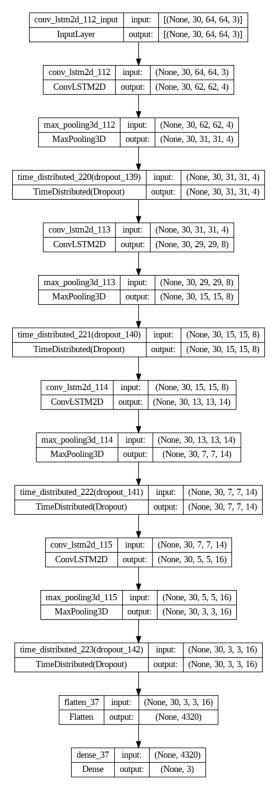

In [128]:
# Save the plot to a file
plot_model(convlstm_model, to_file='convlstm_model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = plt.imread('convlstm_model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

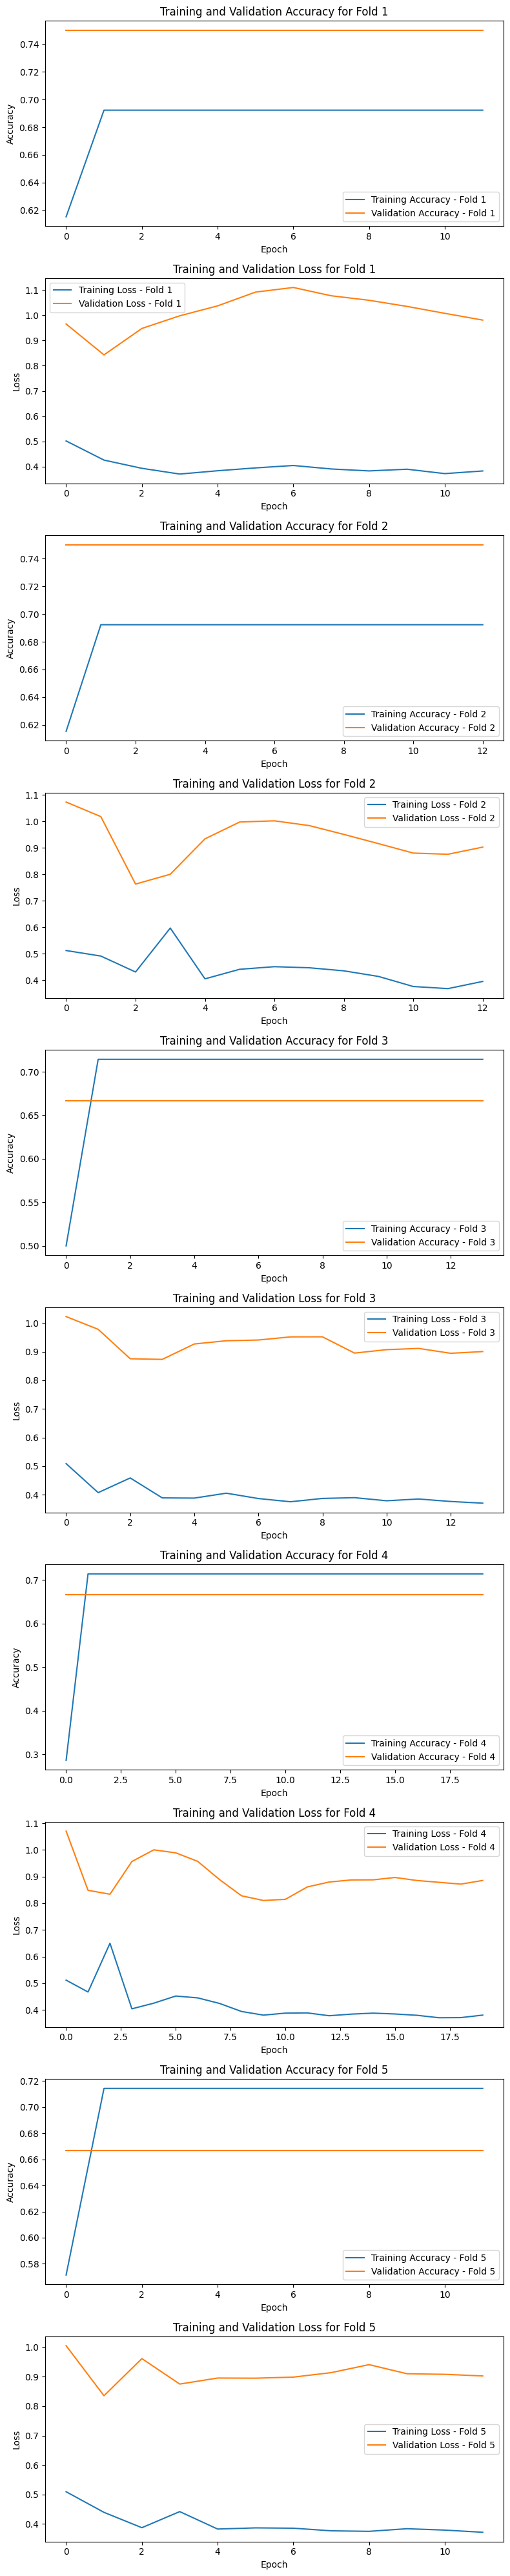

In [123]:
import matplotlib.pyplot as plt

# Assuming 'fold_histories' is a dictionary containing training histories for each fold

# Set the range of fold numbers you want to plot (replace n with the desired upper limit)
n = K_FOLDS
fold_numbers = list(range(1, n + 1))

fig, axs = plt.subplots(2 * len(fold_numbers), 1, figsize=(8, 8 * len(fold_numbers)))

for i, fold_number in enumerate(fold_numbers):
    # Access the history for the specified fold
    history = fold_histories.get(f'fold_{fold_number}', {})

    # Check if the history for the specified fold exists
    if history:
        # Plot training accuracy
        axs[2*i].plot(history['accuracy'], label=f'Training Accuracy - Fold {fold_number}')
        axs[2*i].plot(history['val_accuracy'], label=f'Validation Accuracy - Fold {fold_number}')
        axs[2*i].set_title(f'Training and Validation Accuracy for Fold {fold_number}')
        axs[2*i].set_xlabel('Epoch')
        axs[2*i].set_ylabel('Accuracy')
        axs[2*i].legend()

        # Plot training loss
        axs[2*i+1].plot(history['loss'], label=f'Training Loss - Fold {fold_number}')
        axs[2*i+1].plot(history['val_loss'], label=f'Validation Loss - Fold {fold_number}')
        axs[2*i+1].set_title(f'Training and Validation Loss for Fold {fold_number}')
        axs[2*i+1].set_xlabel('Epoch')
        axs[2*i+1].set_ylabel('Loss')
        axs[2*i+1].legend()
    else:
        print(f'History for Fold {fold_number} not found.')

plt.tight_layout()
plt.show()


In [124]:
def create_LRCN_model():

    # We will use a Sequential model for model construction.
    model = Sequential()



    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [125]:
# Create an empty dictionary to store training histories for each fold
fold_histories = {}
for fold, (train_index, val_index) in enumerate(skf.split(features_train, labels_train.argmax(axis=1))):
    # Split the data into training and validation sets for this fold
    fold_features_train, fold_labels_train = features_train[train_index], labels_train[train_index]
    fold_features_val, fold_labels_val = features_train[val_index], labels_train[val_index]
    # Construct the required LRCN model.
    LRCN_model = create_LRCN_model()
    # Compile the model
    LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

    # Train the model for this fold
    history = LRCN_model.fit(
        x=fold_features_train,
        y=fold_labels_train,
        epochs=50,
        batch_size=4,
        shuffle=True,
        validation_data=(fold_features_val, fold_labels_val),
        callbacks=[early_stopping_callback],
        class_weight=class_weight_dict
    )

    # Save the training history for this fold
    fold_histories[f'fold_{fold + 1}'] = history.history

    # Evaluate the model on the test set for this fold
    test_predictions = convlstm_model.predict(features_test)
    test_pred_classes = np.argmax(test_predictions, axis=1)
    test_true_classes = np.argmax(labels_test, axis=1)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(test_true_classes, test_pred_classes)

    # Print confusion matrix
    print(f"Confusion Matrix - Fold {fold + 1}/{K_FOLDS}:\n{conf_matrix}")

    # Optionally, print classification report
    class_report = classification_report(test_true_classes, test_pred_classes)
    print(f"Classification Report - Fold {fold + 1}/{K_FOLDS}:\n{class_report}")

  warnings.warn(



Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_224 (Time  (None, 30, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_225 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_226 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_227 (Time  (None, 30, 16, 16, 32)    4640      
 Distributed)                                                    
                                                                 
 time_distributed_228 (Time  (None, 30, 4, 4, 32)    

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 1/5:
[[3 0]
 [1 0]]
Classification Report - Fold 1/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_236 (Time  (None, 30, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_237 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_238 (Time  (None, 30, 16, 

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 2/5:
[[3 0]
 [1 0]]
Classification Report - Fold 2/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_248 (Time  (None, 30, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_249 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_250 (Time  (None, 30, 16, 

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 3/5:
[[3 0]
 [1 0]]


  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Classification Report - Fold 3/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_260 (Time  (None, 30, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_261 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_262 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)         

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 4/5:
[[3 0]
 [1 0]]
Classification Report - Fold 4/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_272 (Time  (None, 30, 64, 64, 16)    448       
 Distributed)                                                    
                                                                 
 time_distributed_273 (Time  (None, 30, 16, 16, 16)    0         
 Distributed)                                                    
                                                                 
 time_distributed_274 (Time  (None, 30, 16, 

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))

  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix - Fold 5/5:
[[3 0]
 [1 0]]
Classification Report - Fold 5/5:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           2       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



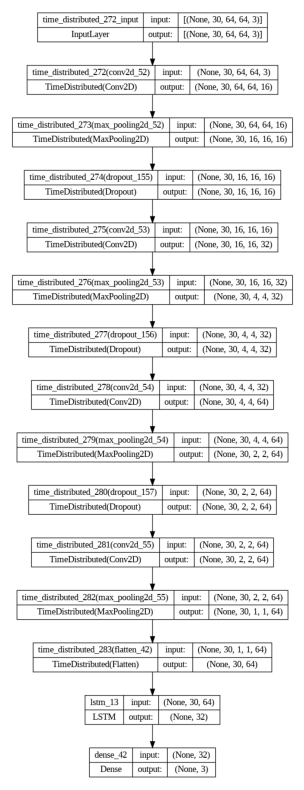

In [129]:
# Save the plot to a file
plot_model(LRCN_model, to_file='convlstm_model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot
img = plt.imread('convlstm_model_plot.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

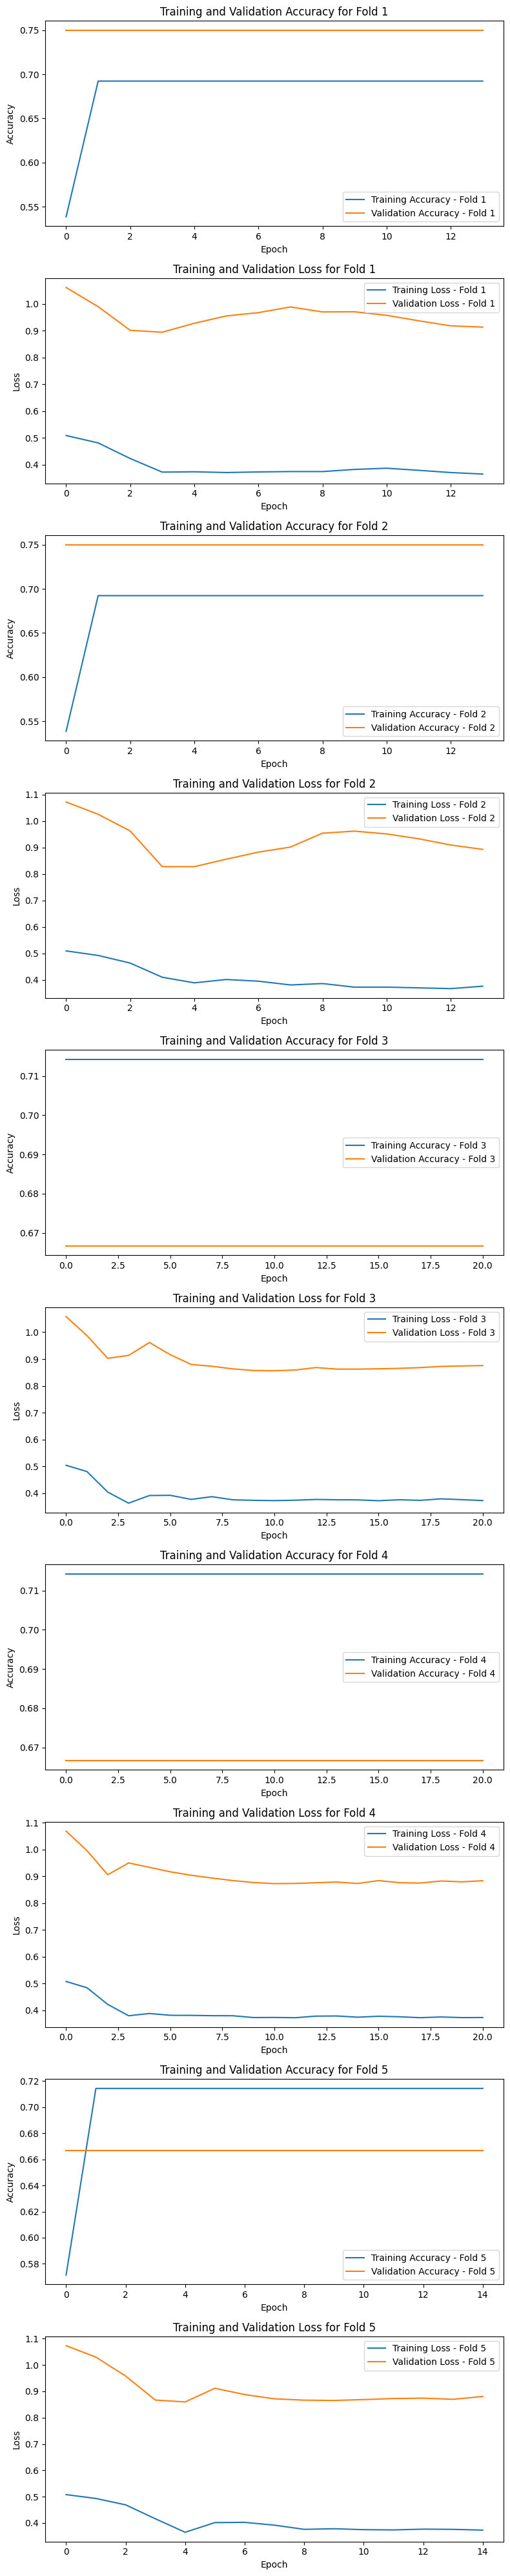

In [126]:
import matplotlib.pyplot as plt

# Assuming 'fold_histories' is a dictionary containing training histories for each fold

# Set the range of fold numbers you want to plot (replace n with the desired upper limit)
n = K_FOLDS
fold_numbers = list(range(1, n + 1))

fig, axs = plt.subplots(2 * len(fold_numbers), 1, figsize=(8, 8 * len(fold_numbers)))

for i, fold_number in enumerate(fold_numbers):
    # Access the history for the specified fold
    history = fold_histories.get(f'fold_{fold_number}', {})

    # Check if the history for the specified fold exists
    if history:
        # Plot training accuracy
        axs[2*i].plot(history['accuracy'], label=f'Training Accuracy - Fold {fold_number}')
        axs[2*i].plot(history['val_accuracy'], label=f'Validation Accuracy - Fold {fold_number}')
        axs[2*i].set_title(f'Training and Validation Accuracy for Fold {fold_number}')
        axs[2*i].set_xlabel('Epoch')
        axs[2*i].set_ylabel('Accuracy')
        axs[2*i].legend()

        # Plot training loss
        axs[2*i+1].plot(history['loss'], label=f'Training Loss - Fold {fold_number}')
        axs[2*i+1].plot(history['val_loss'], label=f'Validation Loss - Fold {fold_number}')
        axs[2*i+1].set_title(f'Training and Validation Loss for Fold {fold_number}')
        axs[2*i+1].set_xlabel('Epoch')
        axs[2*i+1].set_ylabel('Loss')
        axs[2*i+1].legend()
    else:
        print(f'History for Fold {fold_number} not found.')

plt.tight_layout()
plt.show()
